#### Library import

In [87]:
import ast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.io as pio
import seaborn as sns

#### Standard plot parameters

In [88]:
mm = 1 / (2.54 * 10)  # millimeters in inches

# color palettes for different categories
construction_palette = sns.color_palette(["#b1ff9e", "#1dd3af", "#086577"])
model_palette = sns.color_palette(["#faba32", "#ff6e27", "#fc284f"])
threshold_palette = sns.color_palette(["#a7dadc", "#447a9c", "#1d3658"])
weather_palette = sns.color_palette(["#2275a5", "#e93f6f"])


uni_font = 'Helvetica'
uni_fontsize = 7
uni_color = 'black'
hfont = {'fontname':uni_font}

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams.update({"font.size": 7})
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["axes.edgecolor"] = "black"

plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.major.size"] = 3.5
plt.rcParams["xtick.major.width"] = 0.5

plt.rcParams["ytick.left"] = True
plt.rcParams["ytick.major.size"] = 3.5
plt.rcParams["ytick.major.width"] = 0.5

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

plt.rcParams["axes.labelpad"] = 10

### comfortSIM components

In [89]:
# Create different schedules used for filtering data later

schedule_workingday = np.array(
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
)
schedule_weekendday = np.array(
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
)
schedule_workingweek = np.tile(schedule_workingday, 5)
schedule_weekend = np.tile(schedule_weekendday, 2)
schedule_weekly = np.concatenate([schedule_workingweek, schedule_weekend])

schedule_yearly = np.concatenate([schedule_workingday, np.tile(schedule_weekly, 52)])



# THI indices functions

def thi_hourly_area_mean(array):
    result = np.mean(np.ptp(array, axis=0))
    return round(result, 2)


def thi_hourly_area_median(array):
    result = np.median(np.ptp(array, axis=0))
    return round(result, 2)


def thi_hourly_area_std(array):
    result = np.std(np.ptp(array, axis=0))
    return round(result, 2)



def thi_annual_point_mean(array):
    result = np.mean(np.ptp(array, axis=1))
    return round(result, 1)

def thi_annual_point_median(array):
    result = np.median(np.ptp(array, axis=1))
    return round(result, 1) 

def thi_annual_point_std(array):
    result = np.std(np.ptp(array, axis=1))
    return round(result, 1) 

### Model comparison

Defining range for **empirical** model based on ASHRAE Database operative temperature range

In [90]:
ashrae = pd.read_csv(
    "data/ashrae-database/ashrae.csv", low_memory=False,
)

ashrae_subset = ashrae[["thermal_preference", "top"]].dropna()
ashrae_subset = ashrae_subset.loc[(ashrae["thermal_preference"] == 0)]

percentile_10th = np.percentile(ashrae_subset.top, 10).round(1)
percentile_90th = np.percentile(ashrae_subset.top, 90).round(1)

print(f"10th Percentile: {percentile_10th}")
print(f"90th Percentile: {percentile_90th}")

10th Percentile: 21.3
90th Percentile: 29.3


In [91]:
sta_model_data = pd.read_csv("data/dataframes/sta-model-comparison.csv", index_col=0)

sta_model_data.head(5)

,sTA_hourly,Size,Design,Weather,Operation,Model
0,0.00,Small,Standard,TMY,PASSIVE,PMV
1,0.00,Small,Standard,TMY,PASSIVE,PMV
2,0.00,Small,Standard,TMY,PASSIVE,PMV
3,0.13,Small,Standard,TMY,PASSIVE,PMV
4,1.00,Small,Standard,TMY,PASSIVE,PMV


18


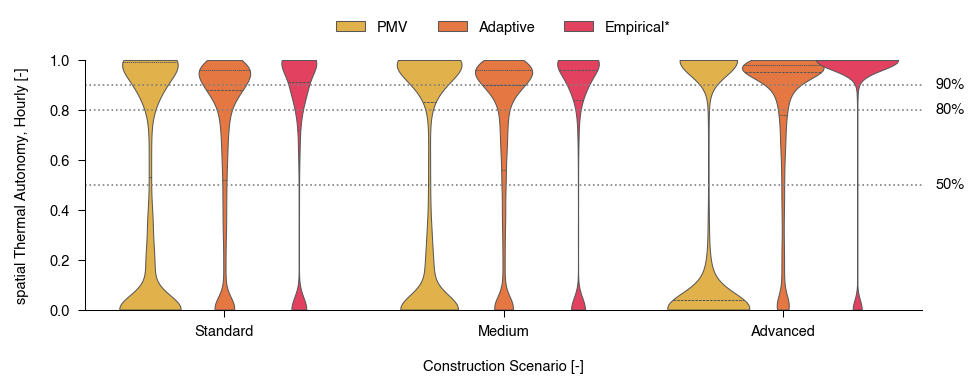

In [92]:
# focus on large zone simulations
figure_data = sta_model_data.loc[sta_model_data["Size"] == "Large"]

# compute number of scenarios to filter
required_repititions = int(len(figure_data) / 8760)
print(required_repititions)

# filter data based on schedule
boolean_filter = schedule_yearly.astype(bool)
boolean_filter_multiplied = np.tile(schedule_yearly.astype(bool), required_repititions)
figure_data = figure_data[boolean_filter_multiplied]

# ----

figure_width = 183 * mm

plt.figure(figsize=(figure_width, 0.3 * figure_width), dpi=150)

plt.axhline(y=0.5, color="gray", linestyle=":", linewidth=0.8)
plt.text(
    x=2.6, y=0.485, s="50%", color="black", ha="center", fontsize=uni_fontsize, **hfont
)

plt.axhline(y=0.8, color="gray", linestyle=":", linewidth=0.8)
plt.text(
    x=2.6, y=0.785, s="80%", color="black", ha="center", fontsize=uni_fontsize, **hfont
)

plt.axhline(y=0.9, color="gray", linestyle=":", linewidth=0.8)
plt.text(
    x=2.6, y=0.885, s="90%", color="black", ha="center", fontsize=uni_fontsize, **hfont
)

sns.violinplot(
    data=figure_data,
    x="Design",
    y="sTA_hourly",
    hue="Model",
    inner="quart",
    palette=model_palette,
    linewidth=0.5,
    gap=-0.1,
    width=0.8,
    cut=0,
    bw_adjust=0.7,
)

plt.grid(axis="y", linestyle="")
plt.xticks(fontsize=uni_fontsize, **hfont)
plt.yticks(fontsize=uni_fontsize, **hfont)
plt.ylim(0, 1)

plt.xlabel("Construction Scenario [-]", fontsize=uni_fontsize, color=uni_color, **hfont)
plt.ylabel(
    "spatial Thermal Autonomy, Hourly [-]",
    fontsize=uni_fontsize,
    color=uni_color,
    **hfont
)
plt.legend(
    bbox_to_anchor=(0.5, 1.05),
    loc="lower center",
    frameon=False,
    fontsize=uni_fontsize,
    title_fontsize=uni_fontsize,
    ncol=len(
        figure_data["Model"].unique()
    ), 
)

plt.savefig(
    "export/img/sta-results-violinplot-large.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

plt.show()

### Spatial heterogeneity

In [93]:
spatial_heterogeneity_data = pd.read_csv(
    "data/dataframes/hourly-spatial-heterogeneity.csv", index_col=0
)

spatial_heterogeneity_data.head(5)

,hourly_spatial_heterogeneity,Size,Design,Weather,Operation
0,0.66,Small,Std,TMY,PASSIVE
1,0.75,Small,Std,TMY,PASSIVE
2,0.77,Small,Std,TMY,PASSIVE
3,0.77,Small,Std,TMY,PASSIVE
4,0.76,Small,Std,TMY,PASSIVE


### Spatial Mapping

In [94]:

# code to generate the spatial heterogeneity plot
small_mapping_data = pd.read_csv("data/dataframes/small-mapping-results.csv", index_col=0)
medium_mapping_data = pd.read_csv("data/dataframes/medium-mapping-results.csv", index_col=0)
large_mapping_data = pd.read_csv("data/dataframes/large-mapping-results.csv", index_col=0)

# this needds to be generated for each scenario
data = small_mapping_data
key = "Small_Std_2070_PASSIVE"
size_factor = 1.2

data["point"] = data["point"].apply(ast.literal_eval)
points = data["point"]

values = data[key]

x, y, z = zip(*points)

x_min = min(x) - 5
x_max = max(x) + 5


def visualize(sim_key=None, save_path=None):

    scatter = go.Scatter(
        x=x,
        y=y,
        mode="markers",
        marker=dict(
            size=25*size_factor,
            color=values,
            colorscale="plasma",
            opacity=1,
            colorbar=dict(title="MRT [°C]"),
            cmin=15,
            cmax=30,
            line=dict(
                color='black',
                width=2
            )
        ),
    )

    layout = go.Layout(
        width=10,
        height=10,
        xaxis=dict(
            title="",
            range=[x_min, x_max],
            zeroline=False,
            showgrid=False,
            showline=False,
            showticklabels=False,
            ticks="",
        ),
        yaxis=dict(
            title="",
            range=[min(y), max(y)],
            zeroline=False,
            showgrid=False,
            showline=False,
            showticklabels=False,
            ticks="",
        ),
        yaxis_scaleanchor="x",
        yaxis_scaleratio=1,
        showlegend=False,
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
    )

    fig = go.Figure(data=[scatter], layout=layout)
    fig.update_layout(
        yaxis=dict(
            scaleanchor="x",
            scaleratio=1,
            autorange=True,
        )
    )

    if save_path:
        fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
        fig.write_image(
            save_path, format="png", engine="kaleido", scale=3, width=800, height=600
        )
    else:
        fig.show()


visualize(sim_key=key, save_path="export/img/mapping" + key + ".png")

### Energy use

In [95]:
annual_energy_use = pd.read_csv(
    "data/dataframes/energy-use.csv"
)

annual_energy_use

,weather,scenario,cooling,heating
0,TMY,Standard,50.5,3.7
1,2070,Standard,97.5,2.1
2,TMY,Medium,43.7,8.1
3,2070,Medium,87.8,3.3
4,TMY,High,27.6,13.2
5,2070,High,61.5,6.1


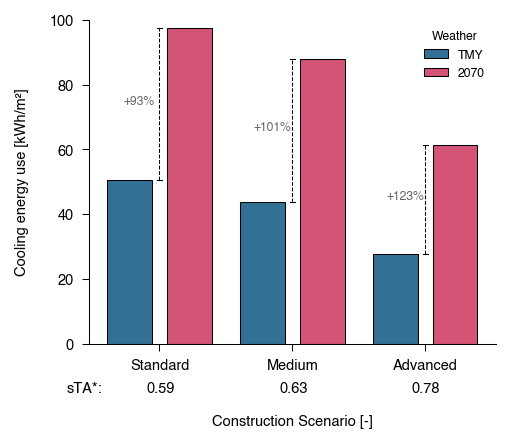

In [96]:
annual_energy_use_tmy = annual_energy_use[annual_energy_use["weather"] == "TMY"]
annual_energy_use_2070 = annual_energy_use[annual_energy_use["weather"] == "2070"]

# merge the dataframes on 'scenario'
annual_energy_use_diff = pd.merge(
    annual_energy_use_tmy,
    annual_energy_use_2070,
    on="scenario",
    suffixes=("_TMY", "_2070"),
)

# calculate the percentage difference
annual_energy_use_diff["percent_diff"] = (
    (annual_energy_use_diff["cooling_2070"] - annual_energy_use_diff["cooling_TMY"])
    / annual_energy_use_diff["cooling_TMY"]
) * 100


figure_width = 89 * mm

plt.figure(figsize=(figure_width, 0.8 * figure_width), dpi=150)
sns.barplot(
    x="scenario",
    y="cooling",
    hue="weather",
    data=annual_energy_use,
    gap=0.25,
    width=0.9,
    palette=weather_palette,
    edgecolor="k",
    linewidth=0.5,
)

# annotate the percentage differences
for index, row in annual_energy_use_diff.iterrows():
    mid_height = (row["cooling_TMY"] + row["cooling_2070"]) / 2
    plt.text(
        index - 0.15,
        mid_height,
        f"+{row['percent_diff']:.0f}%",
        color="dimgrey",
        ha="center",
        fontsize="small",
    )

for index, row in annual_energy_use_diff.iterrows():
    plt.plot(
        [index, index],
        [row["cooling_TMY"], row["cooling_2070"]],
        color="black",
        linestyle="--",
        linewidth=0.5,
    )

    plt.plot(
        [index - 0.02, index + 0.02],
        [row["cooling_TMY"], row["cooling_TMY"]],
        color="black",
        linestyle="-",
        linewidth=0.5,
    )

    plt.plot(
        [index - 0.02, index + 0.02],
        [row["cooling_2070"], row["cooling_2070"]],
        color="black",
        linestyle="-",
        linewidth=0.5,
    )

plt.xlabel("Construction Scenario [-]", fontsize=uni_fontsize, **hfont, labelpad=20)
plt.ylabel("Cooling energy use [kWh/m²]", fontsize=uni_fontsize, **hfont)

plt.text(x=-0.7, y=-15, s='sTA*:')
plt.text(x=-0.1, y=-15, s=0.59)
plt.text(x=0.9, y=-15, s=0.63)
plt.text(x=1.9, y=-15, s=0.78)

plt.grid(axis="y", linestyle="")

plt.ylim(0, 100)

plt.xticks(
    ticks=[0, 1, 2],
    labels=["Standard", "Medium", "Advanced"],
    fontsize=uni_fontsize,
    **hfont
)
plt.yticks(fontsize=uni_fontsize, **hfont)

plt.legend(
    title="Weather",
    title_fontsize="small",
    fontsize="small",
    frameon=False,
)

plt.savefig("export/img/energy-use.png", dpi=300, bbox_inches="tight", transparent=True)

plt.show()

### Temperature distribution (Operation hours)

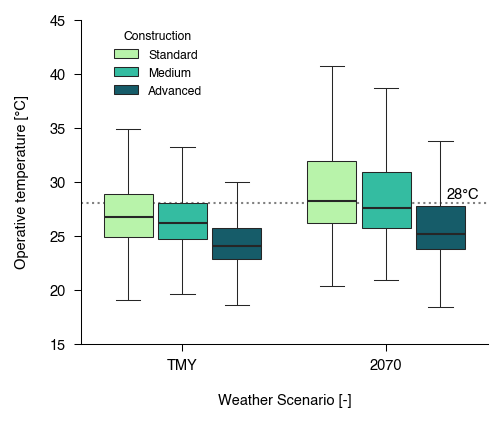

In [97]:
temperature_distribution_data = pd.read_csv("data/dataframes/temperature-distribution.csv", low_memory=False)

#----

figure_width = 89 * mm

plt.figure(figsize=(figure_width, 0.8 * figure_width), dpi=150)

figure_data = temperature_distribution_data

flierprops = dict(marker="o", color="r", alpha=0.1, markersize=3, linewidth=0.5)
medianprops = dict(color='black', linewidth=1)
whiskerprops = dict(linewidth=0.5)
boxprops = dict(linewidth=0.5)
capprops = dict(linewidth=0.5)

plt.axhline(y=28, color="gray", linestyle=":", linewidth=1)
plt.text(
    x=1.375, y=28.5, s="28°C", color="black", ha="center", fontsize=uni_fontsize, **hfont
)

sns.boxplot(
    data=figure_data,
    x="Weather",
    y="point_mrt",
    hue="Design",
    width=0.8,
    gap=0.1,
    showfliers=False,
    palette=construction_palette,
    whiskerprops=whiskerprops,
    boxprops=boxprops,
    capprops=capprops,
)

plt.grid(axis="y", linestyle="")

plt.ylim(15,45)

plt.xticks(fontsize=uni_fontsize, **hfont)
plt.yticks(fontsize=uni_fontsize, **hfont)


plt.xlabel("Weather Scenario [-]", fontsize=uni_fontsize, **hfont)
plt.ylabel("Operative temperature [°C]", fontsize=uni_fontsize, **hfont)
plt.legend(
    title="Construction",
    bbox_to_anchor=(0.325, 1.0),
    frameon=False,
    fontsize="small",
    title_fontsize="small",
)

plt.savefig("export/img/temperature-distribution-reversed.png", dpi=300, bbox_inches="tight", transparent=True)

plt.show()

### Percentage of points grid warmer than 28

In [98]:
elevated_temperature_data = pd.read_csv(
    "data/dataframes/elevated-temperature-results.csv", index_col=0
)

elevated_temperature_data["value_inverse"] = 100 - elevated_temperature_data["value"]

elevated_temperature_data['scenario'] = elevated_temperature_data['scenario'].str.slice(0, 10)

elevated_temperature_data

,scenario,weather,value,value_inverse
0,Medium_Std,TMY,44.18,55.82
1,Medium_Std,2070,29.73,70.27
2,Medium_Med,TMY,52.61,47.39
3,Medium_Med,2070,35.10,64.90
4,Medium_Hig,TMY,92.99,7.01
5,Medium_Hig,2070,74.75,25.25


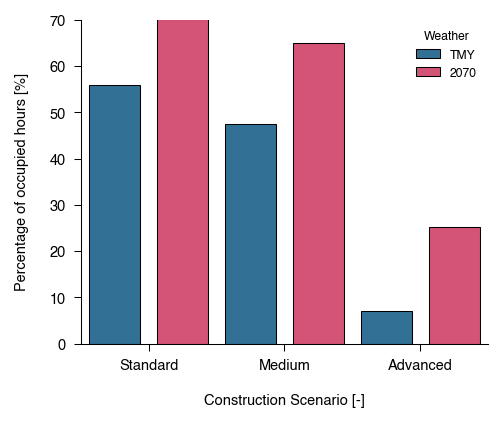

In [99]:
figure_width = 89 * mm

plt.figure(figsize=(figure_width, 0.8 * figure_width), dpi=150)

plt.grid(axis="y", linestyle="")

sns.barplot(
    data=elevated_temperature_data,
    y="value_inverse",
    x="scenario",
    hue="weather",
    gap=0.25,
    width=1,
    palette=weather_palette,
    edgecolor="k",
    linewidth=0.5,
)

plt.ylim(0, 70)

plt.xticks(ticks=[0, 1, 2],labels=["Standard", "Medium", "Advanced"], fontsize=uni_fontsize, **hfont)
plt.yticks(fontsize=uni_fontsize, **hfont)

plt.xlabel("Construction Scenario [-]", fontsize=uni_fontsize, **hfont)
plt.ylabel("Percentage of occupied hours [%]", fontsize=uni_fontsize, **hfont)
plt.legend(
    title="Weather",
    bbox_to_anchor=(1, 1),
    frameon=False,
    fontsize="small",
    title_fontsize="small",
)

plt.savefig("export/img/elevated_temperature.png", dpi=300, bbox_inches="tight")

plt.show()

### THI - Thermal Heterogeneity Indices

In [100]:
thi_data = pd.read_csv("data/dataframes/thi-results.csv", index_col=0)

thi_data.sort_index(ascending=False)

,thi_hourly_area_mean,thi_hourly_area_median,thi_hourly_area_std,thi_annual_point_mean,thi_annual_point_median,thi_annual_point_std
KEY,,,,,,
Small_Std_TMY_PASSIVE_mrt,1.58,0.70,2.08,19.2,18.3,1.7
Small_Std_2070_PASSIVE_mrt,1.58,0.64,2.12,23.0,22.3,1.4
Small_Med_TMY_PASSIVE_mrt,1.43,0.59,1.95,16.8,16.3,1.3
Small_Med_2070_PASSIVE_mrt,1.41,0.54,1.97,20.8,20.5,0.8
Small_High_TMY_PASSIVE_mrt,0.70,0.43,1.08,16.5,16.4,0.3
Small_High_2070_PASSIVE_mrt,0.69,0.40,1.09,17.7,17.7,0.1
Medium_Std_TMY_PASSIVE_mrt,2.13,0.83,2.68,23.9,23.1,1.8
Medium_Std_2070_PASSIVE_mrt,2.12,0.78,2.70,25.9,24.8,1.8
Medium_Med_TMY_PASSIVE_mrt,1.94,0.70,2.54,21.7,21.7,1.7


#### Difference between spatial temperature data and zone mean

In [101]:
spatial_minus_zone_data = pd.read_csv('data/dataframes/spatial-minus-zoneMean-mrt.csv').iloc[:, 1:].round(2)

spatial_minus_zone_data.groupby("Design").describe(percentiles=[0.025,0.25,0.5,0.75, 0.975])

spatial-minus-zoneMean-mrt                                        \
                              count      mean       std   min  2.5%   25%   
Design                                                                      
Advanced                    26280.0  0.285047  1.382687 -1.07 -0.69 -0.39   
Medium                      26280.0  1.212421  2.685641 -1.44 -0.79 -0.46   
Standard                    26280.0  1.284247  2.874403 -1.69 -0.95 -0.54   

                                      
           50%   75%    97.5%    max  
Design                                
Advanced -0.20  0.49  5.54025  17.09  
Medium   -0.25  1.77  8.19000  18.26  
Standard -0.29  1.98  8.67000  18.52

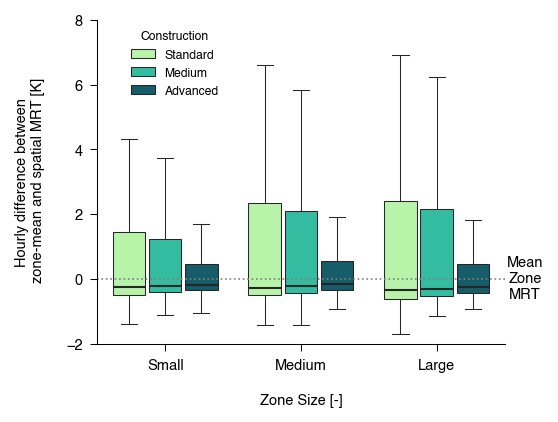

In [102]:
figure_width = 89 * mm

plt.figure(figsize=(figure_width, 0.8 * figure_width), dpi=150)

figure_data = spatial_minus_zone_data

flierprops = dict(marker="o", color="r", alpha=0.1, markersize=3, linewidth=0.5)
medianprops = dict(color='black', linewidth=1)
whiskerprops = dict(linewidth=0.5)
boxprops = dict(linewidth=0.5)
capprops = dict(linewidth=0.5)



sns.boxplot(
    data=figure_data,
    x="Size",
    y="spatial-minus-zoneMean-mrt",
    hue="Design",
    width=0.8,
    gap=0.1,
    showfliers=False,
    palette=construction_palette,
    whiskerprops=whiskerprops,
    boxprops=boxprops,
    capprops=capprops,
)

plt.axhline(y=0, c="gray", linestyle=":", linewidth=0.8)
plt.text(
    x=2.65, y=-0.6, s="Mean\nZone\nMRT", color="black", ha="center", fontsize=uni_fontsize, **hfont
)

plt.grid(axis="y", linestyle="")

plt.ylim(-2, 8)


plt.xticks(fontsize=uni_fontsize, **hfont)
plt.yticks(fontsize=uni_fontsize, **hfont)


plt.xlabel("Zone Size [-]", fontsize=uni_fontsize, **hfont)
plt.ylabel("Hourly difference between\n zone-mean and spatial MRT [K]", fontsize=uni_fontsize, **hfont)
plt.legend(
    title="Construction",
    bbox_to_anchor=(0.325, 1.0),
    frameon=False,
    fontsize="small",
    title_fontsize="small",
)

plt.savefig("export/img/zone-mean-v-spatial.png", dpi=300, bbox_inches="tight")

plt.show()

#### Calculating Annual Spatial Autonomies

In [103]:
hourly_autonomies = pd.read_csv('data/dataframes/sta-model-comparison-by-hour.csv', index_col=0)

# filtering by operational
hourly_autonomies = hourly_autonomies[boolean_filter]

area_percentages = [0.5, 0.8, 0.9]

# empty dictionary to store the results
results = {column: {} for column in hourly_autonomies.columns}

for area_percentage in area_percentages:
    for column in hourly_autonomies.columns:
        annual_spatial_autonomy = np.sum(hourly_autonomies[column] > area_percentage) / hourly_autonomies.shape[0]
        results[column][area_percentage] = annual_spatial_autonomy.round(2)

annual_spatial_autonomy_df = pd.DataFrame(results)
annual_spatial_autonomy_df = annual_spatial_autonomy_df.T
annual_spatial_autonomy_df_reset = annual_spatial_autonomy_df.reset_index()

split_columns = annual_spatial_autonomy_df_reset['index'].str.split('_', expand=True)

split_columns.columns = ['Size','Scenario','Weather','Design','Model']
annual_spatial_autonomy_df_reset = pd.concat([split_columns, annual_spatial_autonomy_df_reset], axis=1).drop(columns=['index'])

annual_autonomy_plot_data = annual_spatial_autonomy_df_reset.melt(id_vars=['Size','Scenario','Weather', 'Model'],value_vars=[0.5, 0.8, 0.9], var_name='area-percentage', value_name='computed-sta')

In [104]:
# filter to get average values
annual_autonomy_plot_data.loc[
    (annual_autonomy_plot_data['Weather'] == 'TMY') &
    (annual_autonomy_plot_data['area-percentage'] == 0.8) &
    (annual_autonomy_plot_data['Model'] == 'adaptive') &
    (annual_autonomy_plot_data['Scenario'] == 'Std')
]

,Size,Scenario,Weather,Model,area-percentage,computed-sta
55,Small,Std,TMY,adaptive,0.8,0.54
73,Medium,Std,TMY,adaptive,0.8,0.57
91,Large,Std,TMY,adaptive,0.8,0.67


In [105]:
annual_autonomy_plot_data

,Size,Scenario,Weather,Model,area-percentage,computed-sta
0,Small,Std,TMY,pmv,0.5,0.52
1,Small,Std,TMY,adaptive,0.5,0.80
2,Small,Std,TMY,temp,0.5,0.87
3,Small,Std,2070,pmv,0.5,0.45
4,Small,Std,2070,adaptive,0.5,0.66
...,...,...,...,...,...,...
157,Large,High,TMY,adaptive,0.9,0.70
158,Large,High,TMY,temp,0.9,0.96
159,Large,High,2070,pmv,0.9,0.37
160,Large,High,2070,adaptive,0.9,0.56


/var/folders/x4/3lxftn1s4zgf32y4j4tqx4kh0000gn/T/ipykernel_12536/1285201260.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



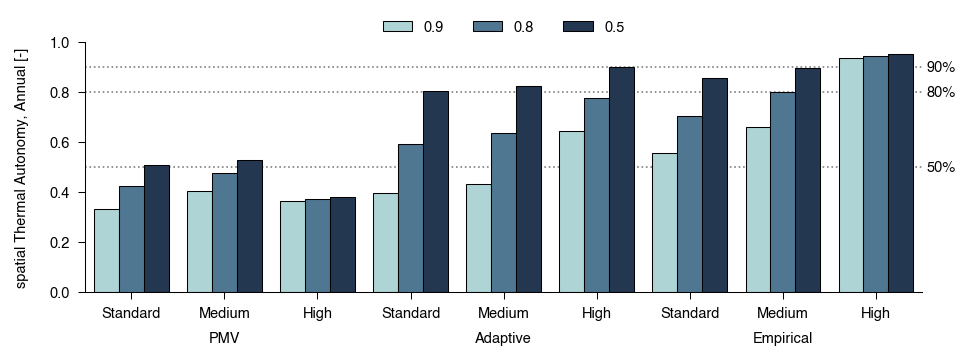

In [106]:
figure_width = 183 * mm

plt.figure(figsize=(figure_width, 0.3 * figure_width), dpi=150)


data = annual_autonomy_plot_data.loc[annual_autonomy_plot_data["Weather"] == "TMY"]

data["Model_Scenario"] = pd.Categorical(data["Model"] + "_" + data["Scenario"])

desired_order = [0.9, 0.8, 0.5]

plt.axhline(y=0.5, color="gray", linestyle=":", linewidth=0.8, zorder=1)
plt.text(
    x=8.7, y=0.485, s="50%", color="black", ha="center", fontsize=uni_fontsize, **hfont
)

plt.axhline(y=0.8, color="gray", linestyle=":", linewidth=0.8, zorder=1)
plt.text(
    x=8.7, y=0.785, s="80%", color="black", ha="center", fontsize=uni_fontsize, **hfont
)

plt.axhline(y=0.9, color="gray", linestyle=":", linewidth=0.8, zorder=1)
plt.text(
    x=8.7, y=0.885, s="90%", color="black", ha="center", fontsize=uni_fontsize, **hfont
)

sns.barplot(
    data=data,
    x="Model_Scenario",
    y="computed-sta",
    hue="area-percentage",
    hue_order=desired_order,
    palette=threshold_palette,
    edgecolor="k",
    linewidth=0.5,
    errorbar=None,
    width=0.8,
    order=[
        "pmv_Std",
        "pmv_Med",
        "pmv_High",
        "adaptive_Std",
        "adaptive_Med",
        "adaptive_High",
        "temp_Std",
        "temp_Med",
        "temp_High",
    ],
)

plt.xticks(
    fontsize=uni_fontsize,
    **hfont,
    labels=["Standard", "Medium", "High"] * 3,
    ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8]
)

plt.ylim(0, 1)

plt.xlabel("", fontsize=uni_fontsize, **hfont)
plt.ylabel("spatial Thermal Autonomy, Annual [-]", fontsize=uni_fontsize, **hfont)

plt.legend(
    bbox_to_anchor=(0.5, 0.98),  # Position the legend at the top center
    loc="lower center",
    frameon=False,
    ncol=len(data["area-percentage"].unique()),
)

plt.text(x=1, y=-0.2, s="PMV", fontsize=uni_fontsize, ha="center", **hfont)
plt.text(x=4, y=-0.2, s="Adaptive", fontsize=uni_fontsize, ha="center", **hfont)
plt.text(x=7, y=-0.2, s="Empirical", fontsize=uni_fontsize, ha="center", **hfont)

plt.savefig(
    "export/img/sta-time-percentage-barplot.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

plt.show()